In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib
pd.set_option("display.max_rows", None)

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")

# 응답율 
투표율에 사용한 기준(10개 학교 유저 + 가입일 < 2023-08-01)

In [3]:
# datetime 컬럼을 datetime 타입으로 변환
votes_df['created_at'] = pd.to_datetime(votes_df['created_at'])
users_df['created_at'] = pd.to_datetime(users_df['created_at'])


In [4]:
# 1. group_id → school_id 매핑을 위해 컬럼명 통일
school_df_renamed = school_df.rename(columns={'id': 'group_id'})

# 2. 유저 가입일 처리
users_df['created_at'] = pd.to_datetime(users_df['created_at'])

# 3. group_id가 있는 유저만 필터 + 8월 1일 이전 가입자 필터링
user_notna_df = users_df[users_df['group_id'].notna()].copy()
user_filtered_df = user_notna_df[user_notna_df['created_at'] < '2023-08-01']

# 4. school_id 병합
school_user_df = user_filtered_df.merge(
    school_df_renamed[['group_id', 'school_id']],
    on='group_id',
    how='left'
)

# 5. 실제 투표가 발생한 10개 학교 ID
valid_school_ids = [271, 369, 5491, 352, 4516, 4426, 1478, 5520, 5372, 1719]

# 6. 해당 학교 소속 유저만 필터링
target_school_users_df = school_user_df[school_user_df['school_id'].isin(valid_school_ids)].copy()


In [10]:
# 2. school_id 병합을 위한 준비
school_df_renamed = school_df.rename(columns={'id': 'group_id'})
users_df['created_at'] = pd.to_datetime(users_df['created_at'])

# 3. 조건: group_id 존재 + 8월 1일 이전 가입자
user_notna_df = users_df[users_df['group_id'].notna()].copy()
user_filtered_df = user_notna_df[user_notna_df['created_at'] < '2023-08-01']

# 4. school_id 병합
school_user_df = user_filtered_df.merge(
    school_df_renamed[['group_id', 'school_id']],
    on='group_id', how='left'
)

# 5. 실제 투표 발생한 10개 학교만
valid_school_ids = [271, 369, 5491, 352, 4516, 4426, 1478, 5520, 5372, 1719]
target_school_users_df = school_user_df[school_user_df['school_id'].isin(valid_school_ids)].copy()



# 7. 최종 유저 ID 목록 추출
target_user_ids = target_school_users_df['id'].unique()
print("최종 대상 유저 수:", len(target_user_ids))

최종 대상 유저 수: 5074


In [11]:
# 1. 대상 유저의 질문 기록만 필터링
uq_df_filtered = votes_df[votes_df['user_id'].isin(target_user_ids)].copy()

# 2. created_at → datetime 처리 및 날짜 파생
uq_df_filtered['created_at'] = pd.to_datetime(uq_df_filtered['created_at'])
uq_df_filtered['date'] = uq_df_filtered['created_at'].dt.date


In [12]:
# 1. 열람 여부 (has_read == 1)
uq_df_filtered['is_read'] = uq_df_filtered['has_read'] == 1

# 2. 응답 여부 (answer_status in ['A', 'P'] → 공개/비공개 답변)
uq_df_filtered['is_answered'] = uq_df_filtered['answer_status'].isin(['A', 'P'])


In [19]:
# 1. 일자별 전체 질문 수, 열람 수, 응답 수
daily_stats_df = (
    uq_df_filtered.groupby('date')
    .agg(total_questions=('id', 'count'),
         read_count=('is_read', 'sum'),
         answered_count=('is_answered', 'sum'))
    .reset_index()
)

# 2. 비율 계산
daily_stats_df['read_rate'] = daily_stats_df['read_count'] / daily_stats_df['total_questions']
daily_stats_df['answer_rate'] = daily_stats_df['answered_count'] / daily_stats_df['total_questions']

# 퍼센트 문자열 컬럼 생성
daily_stats_df['read_rate_percent'] = (daily_stats_df['read_rate'] * 100).round(2).astype(str) + '%'
daily_stats_df['answer_rate_percent'] = (daily_stats_df['answer_rate'] * 100).round(2).astype(str) + '%'

# 기존 소수점 비율 컬럼 삭제
daily_stats_df.drop(['read_rate', 'answer_rate'], axis=1, inplace=True)


In [24]:
# 1. 이전에 만든 투표율 데이터 불러오기
vote_rate_df = pd.read_csv("/home/sprintda05/final/daily_vote_rate.csv")
vote_rate_df['date'] = pd.to_datetime(vote_rate_df['date']).dt.date
# 병합: vote_rate_df와 daily_stats_df를 'date' 기준으로 left join
merged_df = pd.merge(
    vote_rate_df,
    daily_stats_df[['date', 'read_rate_percent', 'answer_rate_percent']],
    on='date',
    how='left'
)



# 3. 결과 미리보기
final_df = merged_df[['date', 'vote_rate_percent', 'read_rate_percent', 'answer_rate_percent']]



In [25]:
final_df

,date,vote_rate_percent,read_rate_percent,answer_rate_percent
0,2023-05-01,72.87%,19.41%,0.2%
1,2023-05-02,75.78%,20.49%,0.33%
2,2023-05-03,80.94%,24.82%,0.63%
3,2023-05-04,73.35%,26.89%,0.89%
4,2023-05-05,80.41%,38.74%,2.5%
5,2023-05-06,75.14%,64.38%,8.98%
6,2023-05-07,68.3%,60.1%,11.6%
7,2023-05-08,60.2%,58.37%,12.76%
8,2023-05-09,56.71%,60.68%,12.96%
9,2023-05-10,54.53%,61.59%,12.71%


In [26]:
merged_df

,date,voted_users,total_users,vote_rate,vote_rate_percent,read_rate_percent,answer_rate_percent
0,2023-05-01,325,446.0,0.728700,72.87%,19.41%,0.2%
1,2023-05-02,413,545.0,0.757798,75.78%,20.49%,0.33%
2,2023-05-03,756,934.0,0.809422,80.94%,24.82%,0.63%
3,2023-05-04,820,1118.0,0.733453,73.35%,26.89%,0.89%
4,2023-05-05,1248,1552.0,0.804124,80.41%,38.74%,2.5%
5,2023-05-06,1375,1830.0,0.751366,75.14%,64.38%,8.98%
6,2023-05-07,1355,1984.0,0.682964,68.3%,60.1%,11.6%
7,2023-05-08,1295,2151.0,0.602046,60.2%,58.37%,12.76%
8,2023-05-09,1318,2324.0,0.567126,56.71%,60.68%,12.96%
9,2023-05-10,1372,2516.0,0.545310,54.53%,61.59%,12.71%


In [27]:
# 1. 일자별 전체 질문 수, 열람 수, 응답 수 계산
daily_stats_df = (
    uq_df_filtered.groupby('date')
    .agg(total_questions=('id', 'count'),
         read_count=('is_read', 'sum'),
         answered_count=('is_answered', 'sum'))
    .reset_index()
)

# 2. 열람률, 응답률 계산
daily_stats_df['read_rate'] = daily_stats_df['read_count'] / daily_stats_df['total_questions']
daily_stats_df['answer_rate'] = daily_stats_df['answered_count'] / daily_stats_df['total_questions']

# 3. 퍼센트 문자열 컬럼 생성
daily_stats_df['read_rate_percent'] = (daily_stats_df['read_rate'] * 100).round(2).astype(str) + '%'
daily_stats_df['answer_rate_percent'] = (daily_stats_df['answer_rate'] * 100).round(2).astype(str) + '%'

# 💡 기존 비율 컬럼은 유지 (read_rate, answer_rate), 삭제하지 않음!

# 4. 투표율 데이터 불러오기 및 날짜 처리
vote_rate_df = pd.read_csv("/home/sprintda05/final/daily_vote_rate.csv")
vote_rate_df['date'] = pd.to_datetime(vote_rate_df['date']).dt.date

# 5. 병합
merged_df = pd.merge(
    vote_rate_df,
    daily_stats_df,  # 전체 컬럼 그대로 병합
    on='date',
    how='left'
)

# 6. 최종 컬럼 정리 (미리보기용)
final_df = merged_df[[
    'date', 'voted_users', 'total_users', 'vote_rate', 'vote_rate_percent',
    'total_questions', 'read_count', 'answered_count',
    'read_rate', 'read_rate_percent',
    'answer_rate', 'answer_rate_percent'
]]


In [28]:
final_df

,date,voted_users,total_users,vote_rate,vote_rate_percent,total_questions,read_count,answered_count,read_rate,read_rate_percent,answer_rate,answer_rate_percent
0,2023-05-01,325,446.0,0.728700,72.87%,12274,2382,25,0.194069,19.41%,0.002037,0.2%
1,2023-05-02,413,545.0,0.757798,75.78%,13663,2799,45,0.204860,20.49%,0.003294,0.33%
2,2023-05-03,756,934.0,0.809422,80.94%,24718,6134,155,0.248159,24.82%,0.006271,0.63%
3,2023-05-04,820,1118.0,0.733453,73.35%,22814,6134,204,0.268870,26.89%,0.008942,0.89%
4,2023-05-05,1248,1552.0,0.804124,80.41%,41509,16082,1039,0.387434,38.74%,0.025031,2.5%
5,2023-05-06,1375,1830.0,0.751366,75.14%,48634,31311,4366,0.643809,64.38%,0.089773,8.98%
6,2023-05-07,1355,1984.0,0.682964,68.3%,44662,26842,5179,0.601003,60.1%,0.115960,11.6%
7,2023-05-08,1295,2151.0,0.602046,60.2%,34200,19962,4365,0.583684,58.37%,0.127632,12.76%
8,2023-05-09,1318,2324.0,0.567126,56.71%,29392,17836,3809,0.606832,60.68%,0.129593,12.96%
9,2023-05-10,1372,2516.0,0.545310,54.53%,30957,19066,3934,0.615887,61.59%,0.127079,12.71%


In [29]:
final_df = final_df.drop(['vote_rate', 'read_rate', 'answer_rate'], axis=1)

In [30]:
final_df

,date,voted_users,total_users,vote_rate_percent,total_questions,read_count,answered_count,read_rate_percent,answer_rate_percent
0,2023-05-01,325,446.0,72.87%,12274,2382,25,19.41%,0.2%
1,2023-05-02,413,545.0,75.78%,13663,2799,45,20.49%,0.33%
2,2023-05-03,756,934.0,80.94%,24718,6134,155,24.82%,0.63%
3,2023-05-04,820,1118.0,73.35%,22814,6134,204,26.89%,0.89%
4,2023-05-05,1248,1552.0,80.41%,41509,16082,1039,38.74%,2.5%
5,2023-05-06,1375,1830.0,75.14%,48634,31311,4366,64.38%,8.98%
6,2023-05-07,1355,1984.0,68.3%,44662,26842,5179,60.1%,11.6%
7,2023-05-08,1295,2151.0,60.2%,34200,19962,4365,58.37%,12.76%
8,2023-05-09,1318,2324.0,56.71%,29392,17836,3809,60.68%,12.96%
9,2023-05-10,1372,2516.0,54.53%,30957,19066,3934,61.59%,12.71%


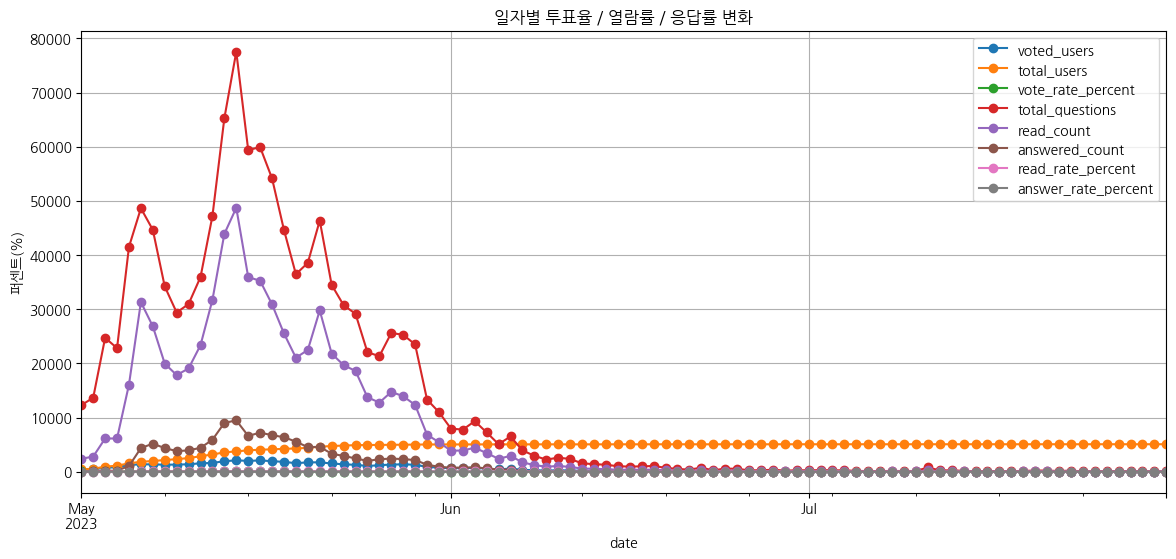

In [41]:
import matplotlib.pyplot as plt

final_df_plot = final_df.copy()
final_df_plot['date'] = pd.to_datetime(final_df_plot['date'])
final_df_plot.set_index('date', inplace=True)

# 문자열 % 제거 후 float로 변환
for col in ['vote_rate_percent', 'read_rate_percent', 'answer_rate_percent']:
    final_df_plot[col] = final_df_plot[col].str.rstrip('%').astype(float)

final_df_plot.plot(figsize=(14, 6), marker='o')
plt.title("일자별 투표율 / 열람률 / 응답률 변화")
plt.ylabel("퍼센트(%)")
plt.grid(True)
plt.show()

In [38]:
import matplotlib.pyplot as plt
print(plt.rcParams['font.family'])

['AppleGothic']


In [40]:
plt.rcParams['font.family'] = 'NanumGothic'

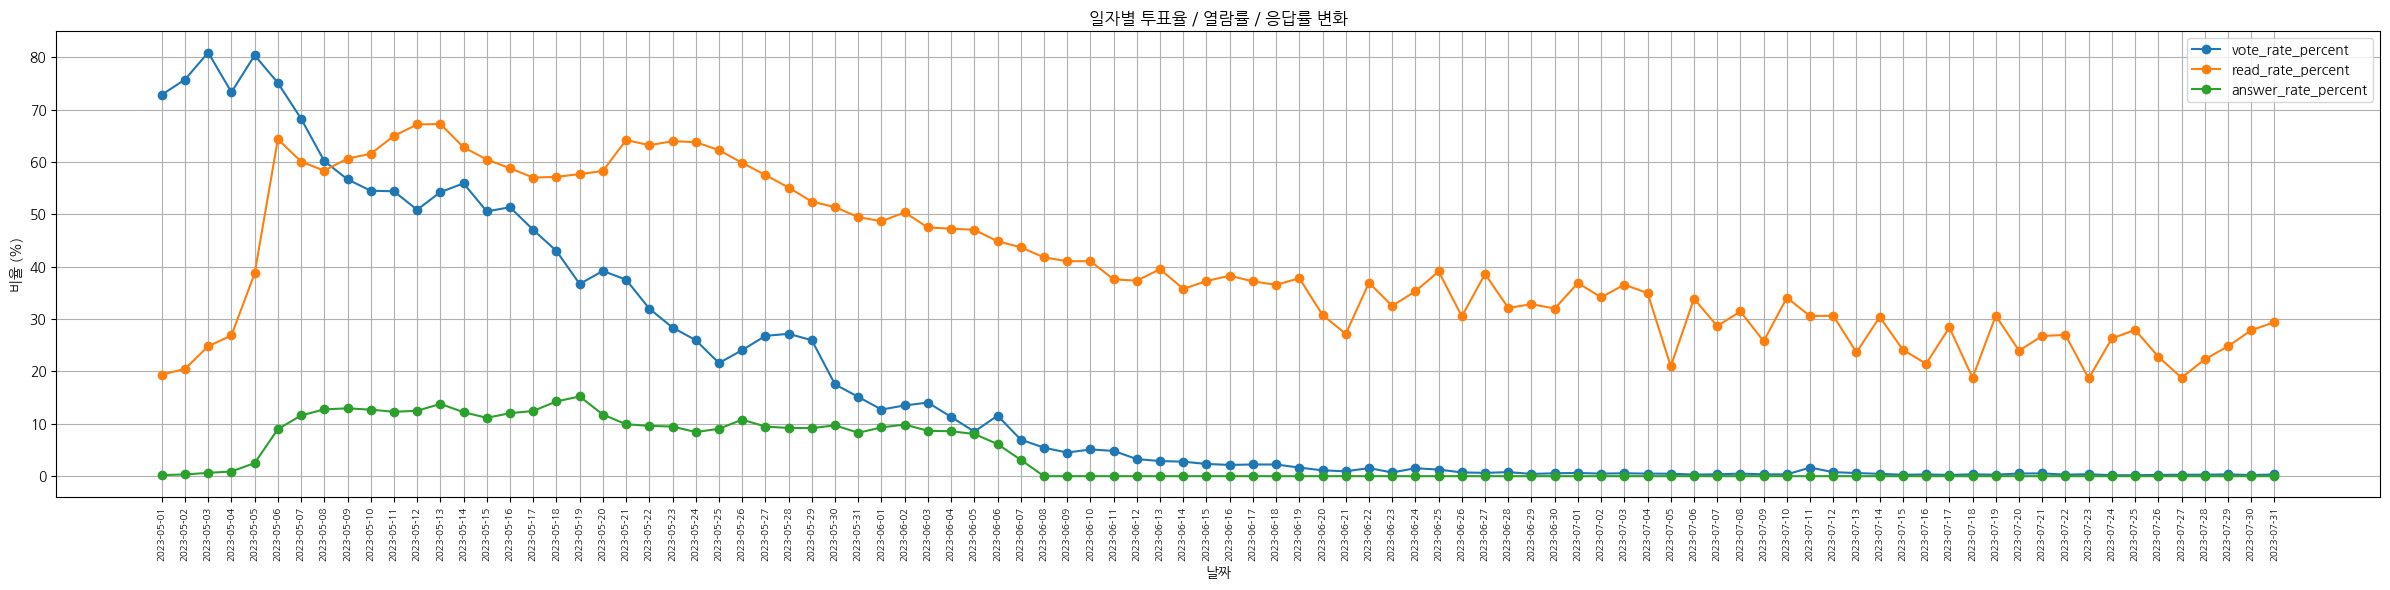

In [43]:
# 퍼센트 문자열 컬럼을 float으로 변환
plot_df = final_df.copy()
for col in ['vote_rate_percent', 'read_rate_percent', 'answer_rate_percent']:
    plot_df[col] = plot_df[col].str.replace('%', '').astype(float)

# 그래프 그리기
plt.figure(figsize=(24, 6))

for col in ['vote_rate_percent', 'read_rate_percent', 'answer_rate_percent']:
    plt.plot(plot_df['date'], plot_df[col], marker='o', label=col)

plt.xticks(ticks=plot_df['date'], labels=plot_df['date'], rotation=90, fontsize=7)

plt.title("일자별 투표율 / 열람률 / 응답률 변화")
plt.xlabel("날짜")
plt.ylabel("비율 (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


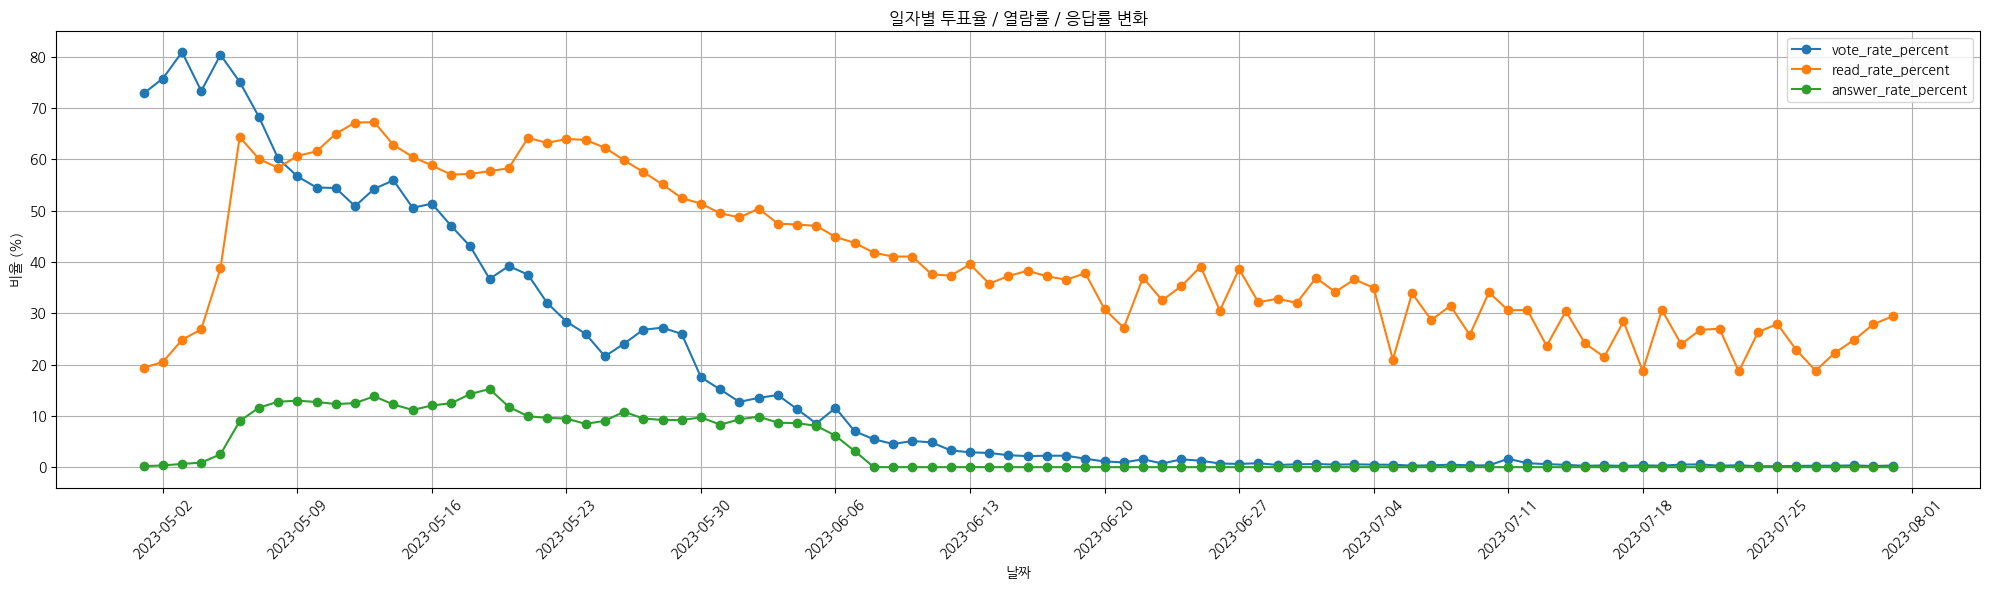

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))

for col in ['vote_rate_percent', 'read_rate_percent', 'answer_rate_percent']:
    plt.plot(plot_df['date'], plot_df[col], marker='o', label=col)

# x축 날짜 간격 설정 (예: 매주 7일 간격)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title("일자별 투표율 / 열람률 / 응답률 변화")
plt.xlabel("날짜")
plt.ylabel("비율 (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()